In [2]:
import time
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

In [80]:
### Functions

def monte_carlo(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Simple Monte Carlo option pricing algorithm for European Calls and Puts with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
        
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    
    def path_sim(mu,sigma,T,S,N, M):
        '''Simulates M paths of Geometric Brownian Motion with N time steps'''
        sims = np.zeros(M) 
        dt = T/N

        for i in range(M):
            W = [0]+np.random.standard_normal(size=N)
            sims[i] = np.sum(W)*np.sqrt(dt) #We only are concerned with the terminal value for European options
        
        St = S*np.exp((mu-0.5*sigma**2)*T + sigma*sims)     
        return St
   
    paths = path_sim(r-q,sigma,T,S,n,m)
    
    if CallPut == 'Call':
        paths = paths - K
        
        # print("paths:", paths)        
        # `x[idx] = y``, use ``x = x.at[idx].set(y)
        
        # paths[paths < 0] = 0
        
        # paths = paths.at[paths < 0].set(0)     
        
        # paths = [max(0, path) for path in paths]   
        
        new_paths = []
        
        for path in paths:
            
            if path > 0:
                new_paths.append(path)
                
            else:
                new_paths.append(0)
                
        new_paths = np.array(new_paths)
                
        paths = new_paths     
   
        
    
    elif CallPut == 'Put':
        paths = K - paths
        paths[paths < 0] = 0
    
    c_hat = np.mean(paths)*np.exp(-r*T)
    
    sd = np.sqrt(np.sum((paths*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)       
    return c_hat, sd, se


def monte_carlo_AV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo option pricing algorithm for European Calls and Puts with Antithetic Variance Reduction
    with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
        
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def path_sim(mu,sigma,T,S,N, M):
        '''Simulates M paths of Geometric Brownian Motion with N time steps incorporating antithetic variance reduction'''
        sims = np.zeros(M)
        dt = T/N

        for i in range(M):
            W = [0]+np.random.standard_normal(size=N)
            sims[i] = np.sum(W)*np.sqrt(dt) #we are concerned with only the final value of the path
        
        St = S*np.exp((mu-0.5*sigma**2)*T + sigma*sims)
        Sta = S*np.exp((mu-0.5*sigma**2)*T - sigma*sims)    
        return np.array([St, Sta])
        
    paths = path_sim(r-q,sigma,T,S,n,m)
    
    if CallPut == 'Call':
        paths = paths - K
        paths[paths < 0] = 0
    
    elif CallPut == 'Put':
        paths = K - paths
        paths[paths < 0] = 0
    
    cT = np.mean(paths, axis=0)
    c_hat = np.mean(paths)*np.exp(-r*T)
    
    sd = np.sqrt(np.sum((cT*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
    return c_hat, sd, se


def monte_carlo_deltCV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta-based Control Variate with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, c_p):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        if c_p == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif c_p == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
        
    def path_sim(mu,sigma,T,S,N, M, cp,K):
        '''Simulates M paths of Geometric Brownian Motion with N time steps incorporating antithetic variance reduction'''
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t) 
        erddt = np.exp((r-q)*dt)      
        for i in range(M):
            # GBM paths:
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((mu-0.5*sigma**2)*t + sigma*W)
            
            # Delta CV:
            d = delta(St[0:N-1],K,ttm[0:N-1],mu,sigma,cp)                
            cv = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            sims[i] = [St[-1], cv]
        return np.array(sims).T

    paths = path_sim(r-q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff:
        paths[0] = paths[0] - K
        paths[0][paths[0] < 0] = 0
        
        # Control Variate:
        paths = paths[0] - paths[1]
        
    elif CallPut == 'Put':
        # Option payoff:
        paths[0] = K - paths[0]
        paths[0][paths[0] < 0] = 0
        
        # Control Variate:
        paths = paths[0] - paths[1]
    
    c_hat = np.mean(paths)*np.exp(-r*T)    
    sd = np.sqrt(np.sum((paths*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
      
    return c_hat, sd, se


def monte_carlo_delt_gamCV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta-based and Gamma-based Control Variates with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, CallPut):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        if CallPut == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif CallPut == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
    
    def gamma(S, K, T, r, q, sigma):
        '''Black-Scholes gamma'''
        d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return (np.exp(-q*T)/(S*sigma*np.sqrt(T))) * ((2*np.pi)**(-0.5)) * np.exp(-0.5*d1**2)
    
    def path_sim(r,q,sigma,T,S,N, M,CallPut,K):
        '''Simulates paths of Geometric Brownian motion while implementing the control variates'''
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t) 
        erddt = np.exp((r-q)*dt)   
        egamma = np.exp((2*(r-q) + sigma**2)*dt) - 2*erddt + 1

        for i in range(M):
            # GBM path:
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((r-q-0.5*sigma**2)*t + sigma*W)
            
            # Delta CV:
            d = delta(St[0:N-1],K,ttm[0:N-1],r-q,sigma,CallPut)                
            cv_d = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp((r-q)*ttm[1:N]))
            
            # Gamma CV:
            g = gamma(St[0:N-1], K, ttm[0:N-1], r,q, sigma)     
            cv_g = np.sum(g*(((St[1:N] - St[0:N-1])**2) - egamma*St[0:N-1]**2)*np.exp((r-q)*ttm[1:N]))
            sims[i] = [St[-1], cv_d, cv_g]
        return np.array(sims).T
        
    paths = path_sim(r,q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff:
        paths[0] = paths[0] - K
        paths[0][paths[0] < 0] = 0
        
        # Control Variates:
        paths = paths[0] - paths[1]- 0.5*paths[2]
        
    elif CallPut == 'Put':
        # Option payoff:
        paths[0] = K - paths[0]
        paths[0][paths[0] < 0] = 0
        
        # Control Variates:
        paths = paths[0] - paths[1] - 0.5*paths[2]
    
    c_hat = np.mean(paths)*np.exp(-r*T)    
    sd = np.sqrt(np.sum((paths*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
      
    return c_hat, sd, se



def monte_carlo_deltCV_AV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta-based Control Variate and Antithetic Variate
    with Euler discretization.
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, c_p):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + T*(r + 0.5*sigma**2))/(sigma*np.sqrt(T))
        if c_p == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif c_p == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
        
    def path_sim(mu,sigma,T,S,N, M, cp,K):
        '''Simulates M paths of Geometric Brownian Motion with N time steps incorporating antithetic variance reduction'''
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t)  
        erddt = np.exp((r-q)*dt)    

        for i in range(M):         
            # GBM paths:
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((mu-0.5*sigma**2)*t + sigma*W);            Sta = S*np.exp((mu-0.5*sigma**2)*t - sigma*W)
            
            # Delta CV:
            d = delta(St[0:N-1],K,ttm[0:N-1],mu,sigma,cp);            da = delta(Sta[0:N-1],K,ttm[0:N-1],mu,sigma,cp)
            cv = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            cva = np.sum(da*(Sta[1:N] - (Sta[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            sims[i] = [St[-1], Sta[-1], cv, cva]
        
        return np.array(sims).T
    
    paths = path_sim(r-q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff:
        paths[0] = paths[0] - K; paths[1] = paths[1] - K
        paths[0][paths[0] < 0] = 0; paths[1][paths[1] < 0] = 0
        
        # Control Variate:
        paths[0] = paths[0] - paths[2]
        paths[1] = paths[1] - paths[3]
        
    elif CallPut == 'Put':
        # Option payoff:
        paths[0] = K - paths[0]; paths[1] = K - paths[1]
        paths[0][paths[0] < 0] = 0; paths[1][paths[1] < 0] = 0
        
        # Control Variate:
        paths[0] = paths[0] + beta1*paths[2]
        paths[1] = paths[1] + beta1*paths[3]
    
    cT = np.mean(paths[0:2], axis=0)
    c_hat = np.mean(paths[0:2])*np.exp(-r*T)
    
    sd = np.sqrt(np.sum((cT*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
       
    return c_hat, sd, se



def monte_carlo_delt_gamCV_AV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta and Gamma-based Control Variate and Antithetic Variate.
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, c_p):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + T*(r + 0.5*sigma*sigma))/(sigma*np.sqrt(T))
        if c_p == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif c_p == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
        
    def gamma(S, K, T, r, q, sigma):
        '''Black-Scholes gamma'''
        d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return (np.exp(-q*T)/(S*sigma*np.sqrt(T))) * ((2*np.pi)**(-0.5)) * np.exp(-0.5*d1**2)
    
        
    def path_sim(mu,sigma,T,S,N, M, cp,K):
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t)  
        erddt = np.exp((r-q)*dt)    
        egamma = np.exp((2*(r-q) + sigma**2)*dt) - 2*erddt + 1

        for i in range(M):         
            # GBM paths
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((mu-0.5*sigma**2)*t + sigma*W);            Sta = S*np.exp((mu-0.5*sigma**2)*t - sigma*W)
            
            # Delta-based control variate
            d = delta(St[0:N-1],K,ttm[0:N-1],mu,sigma,cp);            da = delta(Sta[0:N-1],K,ttm[0:N-1],mu,sigma,cp)
            cv_d = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            cva_d = np.sum(da*(Sta[1:N] - (Sta[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            
            # Gamma-based control variate
            g = gamma(St[0:N-1], K, ttm[0:N-1], r,q, sigma);        ga = gamma(Sta[0:N-1],K,ttm[0:N-1],r,q,sigma)
            cv_g = np.sum(g*(((St[1:N] - St[0:N-1])**2) - egamma*St[0:N-1]**2)*np.exp((r-q)*ttm[1:N]))           
            cva_g = np.sum(ga*(((Sta[1:N] - Sta[0:N-1])**2) - egamma*Sta[0:N-1]**2)*np.exp((r-q)*ttm[1:N]))
            
            sims[i] = [St[-1], Sta[-1], cv_d, cva_d, cv_g, cva_g]
        return np.array(sims).T

    paths = path_sim(r-q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff
        paths[0] = paths[0] - K;            paths[1] = paths[1] - K
        paths[0][paths[0] < 0] = 0;         paths[1][paths[1] < 0] = 0
        
        # Control Variates:
        paths[0] = paths[0] - paths[2] - 0.5*paths[4]
        paths[1] = paths[1] - paths[3] - 0.5*paths[5]
        
    elif CallPut == 'Put':
        # Option payoff
        paths[0] = K - paths[0];            paths[1] = K - paths[1]
        paths[0][paths[0] < 0] = 0;         paths[1][paths[1] < 0] = 0
        
        # Control Variates:
        paths[0] = paths[0] - paths[2] - 0.5*paths[4]
        paths[1] = paths[1] - paths[3] - 0.5*paths[5]
    
    cT = np.mean(paths[0:2], axis=0)
    c_hat = np.mean(paths[0:2])*np.exp(-r*T)

    sd = np.sqrt(np.sum((cT*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
       
    return c_hat, sd, se

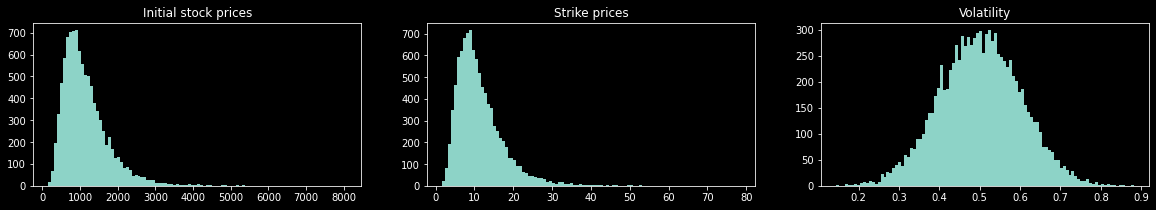

In [81]:
### MC Parameters

SAMPLES_COUNT = 10000

BINS_COUNT = 100


### Fixed

T = time_to_maturity = 1 # one year

n = time_steps_count = 1

m = paths_count = 10

CallPut = option_type = 'Call'


# Within bounds

q_min = dividend_rate_min = 0.01
q_max = dividend_rate_max = 0.1

q = dividend_rate = q_min

r_min = risk_free_interest_rate_min = 0.01
r_max = risk_free_interest_rate_max = 0.03

r = risk_free_interest_rate = r_min


# # Ranges

# S_min = initial_stock_price_min = 0
# S_max = initial_stock_price_min = 445000

# K_min = strike_price_min = 0
# K_max = strike_price_max = 445000

# sigma_min = volatility_min = 0
# sigma_max = volatility_max = 1


### Random

# Intial stock prices

lognormal_inner_mean = 0
lognormal_inner_sigma = 0.5

initial_stock_prices_mean = 1000

initial_stock_prices = np.random.lognormal(mean=lognormal_inner_mean,
                                           sigma=lognormal_inner_sigma,
                                           size=SAMPLES_COUNT)

initial_stock_prices *= initial_stock_prices_mean


# Strike prices

lognormal_inner_mean = 0
lognormal_inner_sigma = 0.5

strike_prices_mean = 10

strike_prices = np.random.lognormal(mean=lognormal_inner_mean,
                                    sigma=lognormal_inner_sigma,
                                    size=SAMPLES_COUNT)

strike_prices *= strike_prices_mean


# Volatilities

volatility_min = 0
volatility_max = 1

volatility_mean = 0.5
volatility_std = 0.1

def get_truncated_normal(minimum, maximum, mean, std):
    
    truncated_normal_distribution = si.truncnorm(
        (minimum - mean) / std, 
        (maximum - mean) / std, 
        loc=mean, 
        scale=std
    )
    
    return truncated_normal_distribution

truncated_normal_distribution = get_truncated_normal(minimum=volatility_min,
                                                     maximum=volatility_max,
                                                     mean=volatility_mean,
                                                     std=volatility_std)

volatilities = truncated_normal_distribution.rvs(SAMPLES_COUNT)


### Plot random parameters

plt.style.use('dark_background')

figure, row = plt.subplots(1, 3, figsize=(20, 3))

row[0].hist(initial_stock_prices, 100);
row[1].hist(strike_prices, 100);
row[2].hist(volatilities, 100);

row[0].set_title("Initial stock prices")
row[1].set_title("Strike prices")
row[2].set_title("Volatility");

In [82]:
initial_stock_prices.shape[0]

10000

In [83]:
# JAX

import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)


# GPUs

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(6, 16)))

jax.devices()

[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0),
 GpuDevice(id=4, process_index=0),
 GpuDevice(id=5, process_index=0),
 GpuDevice(id=6, process_index=0),
 GpuDevice(id=7, process_index=0),
 GpuDevice(id=8, process_index=0),
 GpuDevice(id=9, process_index=0)]

In [84]:
def test_mc(S, K, T, r, q, sigma, CallPut, n, m):
    
    return (S, K, T, r, q, sigma, n, m)


def test_mc_simple(S, T):
    
    return S

initial_stock_price = 1000
strike_price = 100
volatility = 0.5

result = test_mc(S=initial_stock_price, 
                 K=strike_price,
                 T=time_to_maturity, 
                 r=risk_free_interest_rate,
                 q=dividend_rate, 
                 sigma=volatility, 
                 CallPut=option_type, 
                 n=time_steps_count,
                 m=paths_count)

print("Result:", result)


initial_stock_prices = jnp.array([1000, 2000])

vmapped_test_mc = jax.vmap(test_mc,
                           in_axes=(0, None, None, None, None, None, None, None, None))

vmapped_result = vmapped_test_mc(initial_stock_prices, 
                 strike_price,
                 time_to_maturity, 
                 risk_free_interest_rate,
                 dividend_rate, 
                 volatility, 
                 option_type, 
                 time_steps_count,
                 paths_count)


print("vmapped_result:", vmapped_result)

Result: (1000, 100, 1, 0.01, 0.01, 0.5, 1, 10)
vmapped_result: (DeviceArray([1000, 2000], dtype=int64), DeviceArray([100, 100], dtype=int64, weak_type=True), DeviceArray([1, 1], dtype=int64, weak_type=True), DeviceArray([0.01, 0.01], dtype=float64, weak_type=True), DeviceArray([0.01, 0.01], dtype=float64, weak_type=True), DeviceArray([0.5, 0.5], dtype=float64, weak_type=True), DeviceArray([1, 1], dtype=int64, weak_type=True), DeviceArray([10, 10], dtype=int64, weak_type=True))


In [85]:
def test_function(a, b, c):
    
    return a + b + c

vmapped_test_function = jax.vmap(test_function,
                                 in_axes = (0, None, 0))

a_s = jnp.array([0, 1])
b_s = 10
c_s = jnp.array([100, 200])

result = vmapped_test_function(a_s, b_s, c_s)

print("Result:", result)

Result: [110 211]


In [86]:
vmapped_mc = jax.vmap(monte_carlo,
                      in_axes=(0, None, None, None, None, None, None, None, None))

initial_stock_prices = jnp.array([1000, 2000])
strike_price = 100
volatility = 0.5

result = vmapped_mc(S=initial_stock_prices, 
                     K=strike_price,
                     T=time_to_maturity, 
                     r=risk_free_interest_rate,
                     q=dividend_rate, 
                     sigma=volatility, 
                     CallPut=option_type, 
                     n=time_steps_count,
                     m=paths_count)

print("Result:", result)

# ,
                                # axis_name='filters',
                                # static_broadcasted_argnums=[2, 3, 4, 6, 7, 8],
                                # in_axes=(None, 0, None),
                               # )
    
#     result = vmapped_function()
    
#     result = vmapped_function(S=initial_stock_prices, 
#                                   K=strike_prices,
#                                   T=time_to_maturity, 
#                                   r=risk_free_interest_rate,
#                                   q=dividend_rate, 
#                                   sigma=volatilities, 
#                                   CallPut=option_type, 
#                                   n=time_steps_count,
#                                   m=paths_count)
    
#     continue

AssertionError: 

In [87]:
### Calculate and plot

monte_carlo_functions = [
    {'name': 'monte_carlo', 'function': monte_carlo, 
     'description': "Simple Monte Carlo"},
    {'name': 'monte_carlo_AV', 'function': monte_carlo_AV, 
     'description': "MC with Antithetic Variance Reduction"},
    {'name': 'monte_carlo_deltCV', 'function': monte_carlo_deltCV, 
     'description': "MC with Delta-based Control Variate"},
    {'name': 'monte_carlo_delt_gamCV', 'function': monte_carlo_delt_gamCV, 
     'description': "MC with Delta-based and Gamma-based Control Variates "},
    {'name': 'monte_carlo_deltCV_AV', 'function': monte_carlo_deltCV_AV, 
     'description': "MC with Delta-based Control Variate and Antithetic Variate "},
    {'name': 'monte_carlo_delt_gamCV_AV', 'function': monte_carlo_delt_gamCV_AV, 
     'description': "MC with Delta and Gamma-based Control Variate and Antithetic Variate"},
]

# figure, row = plt.subplots(1, len(monte_carlo_functions), 
#                             figsize=(20, 3), 
#                             sharex='row', sharey='row')

# row[0].set_ylabel("Samples count");

for function_index, function in enumerate(monte_carlo_functions[:1]):
    
    c_hats = []
    
    print(f"{function_index + 1}) {function['description']}")
    
    start_time = time.time()
    
    
    
    # JAX
    
    strike_price = 100
    volatility = 0.5
    
    vmapped_function = jax.vmap(function['function'],
                                in_axes=(0, None, None, None, None, None, None, None, None))

    vmapped_result = vmapped_function(initial_stock_prices, 
                     strike_price,
                     time_to_maturity, 
                     risk_free_interest_rate,
                     dividend_rate, 
                     volatility, 
                     option_type, 
                     time_steps_count,
                     paths_count)
    
    
    print("vmapped_result:", vmapped_result)
    
    continue
    
    
    
    for initial_stock_price, strike_price, volatility in zip(initial_stock_prices, 
                                                             strike_prices, 
                                                             volatilities):
                
        result = function['function'](S=initial_stock_price, 
                                      K=strike_price,
                                      T=time_to_maturity, 
                                      r=risk_free_interest_rate,
                                      q=dividend_rate, 
                                      sigma=volatility, 
                                      CallPut=option_type, 
                                      n=time_steps_count,
                                      m=paths_count)
        
        c_hat, sd, se = result
        
        c_hats.append(c_hat)
        
    execution_time = time.time() - start_time
    
    print(f"{len(c_hats)} samples - {execution_time:.2f} s.")
    
#     cell = row[function_index]

#     cell.hist(c_hats, BINS_COUNT)
#     cell.set_xlabel("Price")

    plt.figure(figsize=(5, 3))
    
    plt.hist(c_hats, BINS_COUNT)
    plt.xlabel("Price")
    plt.ylabel("Samples count")

    plt.show()

1) Simple Monte Carlo


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[])>with<BatchTrace(level=1/0)> with
  val = DeviceArray([ True,  True], dtype=bool)
  batch_dim = 0
The problem arose with the `bool` function. 
This Tracer was created on line /tmp/ipykernel_23678/980326339.py:48 (monte_carlo)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError